# 📈 Temporal Impact Analysis - GRU Model

## Comprehensive Analysis of Short-term vs Long-term Impact Patterns

**Objective:** Compare the short-term (12w) vs. long-term (24w) impact of demographics, clinical conditions, and mindfulness interventions

**Key Analysis Components:**
- ⏰ Temporal Feature Evolution Analysis
- 🔄 Short vs Long-term Predictor Comparison
- 👥 Demographics Impact Over Time
- 🏥 Clinical Progression Analysis
- 💊 Mindfulness Intervention Effectiveness
- 📊 Recovery Pattern Identification

---
**GRU Model Performance:**
- 12w: MAE 4.533 ± 0.712, R² 0.233
- 24w: Expected similar performance
---

In [1]:
# 📚 Import Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning & Time Series Analysis
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr, wilcoxon, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# File handling and utilities
import json
from pathlib import Path
from datetime import datetime
import itertools

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("🚀 Libraries loaded successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🚀 Libraries loaded successfully!
📅 Analysis Date: 2025-09-30 22:10:25


In [2]:
# 📂 Load Data and Previous Analysis Results
BASE_PATH = Path(r'c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN')
DATA_PATH = BASE_PATH / 'Track1_Data' / 'processed'
RESULTS_PATH = BASE_PATH / 'Results'

# Load dataset
train_data = pd.read_excel(DATA_PATH / 'train_engineered_features.xlsx')
test_data = pd.read_excel(DATA_PATH / 'test_split.xlsx')

# Load feature metadata
with open(DATA_PATH / 'feature_metadata.json', 'r') as f:
    feature_metadata = json.load(f)

feature_cols = feature_metadata['feature_columns']
target_cols = feature_metadata['target_columns']

print("📊 Dataset Overview:")
print(f"   Training samples: {len(train_data)}")
print(f"   Features: {len(feature_cols)}")
print(f"   Targets: {target_cols}")

# Load previous feature importance results if available
try:
    importance_12w = pd.read_csv(RESULTS_PATH / 'feature_importance_12w_summary.csv')
    importance_24w = pd.read_csv(RESULTS_PATH / 'feature_importance_24w_summary.csv')
    print("✅ Previous feature importance analysis loaded!")
except:
    print("⚠️ Previous analysis not found - will compute importance if needed")
    importance_12w = None
    importance_24w = None

📊 Dataset Overview:
   Training samples: 167
   Features: 33
   Targets: ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w']
✅ Previous feature importance analysis loaded!


In [3]:
# 📊 Data Exploration - Temporal Patterns
print("📊 Exploring temporal patterns in depression scores...")

# Basic statistics for both timepoints
temporal_stats = pd.DataFrame({
    'Timepoint': ['Baseline', '12 Weeks', '24 Weeks'],
    'Mean': [
        train_data['bdi_ii_baseline'].mean(),
        train_data['bdi_ii_after_intervention_12w'].mean(),
        train_data['bdi_ii_follow_up_24w'].mean()
    ],
    'Std': [
        train_data['bdi_ii_baseline'].std(),
        train_data['bdi_ii_after_intervention_12w'].std(),
        train_data['bdi_ii_follow_up_24w'].std()
    ],
    'Min': [
        train_data['bdi_ii_baseline'].min(),
        train_data['bdi_ii_after_intervention_12w'].min(),
        train_data['bdi_ii_follow_up_24w'].min()
    ],
    'Max': [
        train_data['bdi_ii_baseline'].max(),
        train_data['bdi_ii_after_intervention_12w'].max(),
        train_data['bdi_ii_follow_up_24w'].max()
    ]
})

print("\n📈 BDI-II Score Evolution:")
print(temporal_stats.round(2))

# Calculate improvement metrics
train_data['improvement_12w'] = train_data['bdi_ii_baseline'] - train_data['bdi_ii_after_intervention_12w']
train_data['improvement_24w'] = train_data['bdi_ii_baseline'] - train_data['bdi_ii_follow_up_24w']
train_data['improvement_12w_pct'] = (train_data['improvement_12w'] / train_data['bdi_ii_baseline']) * 100
train_data['improvement_24w_pct'] = (train_data['improvement_24w'] / train_data['bdi_ii_baseline']) * 100

# Response categories
train_data['response_12w'] = train_data['improvement_12w_pct'] >= 50  # 50% improvement = response
train_data['response_24w'] = train_data['improvement_24w_pct'] >= 50
train_data['remission_12w'] = train_data['bdi_ii_after_intervention_12w'] <= 13  # BDI <= 13 = remission
train_data['remission_24w'] = train_data['bdi_ii_follow_up_24w'] <= 13

print("\n🎯 Treatment Response Rates:")
print(f"   12w Response (≥50% improvement): {train_data['response_12w'].mean():.1%}")
print(f"   24w Response (≥50% improvement): {train_data['response_24w'].mean():.1%}")
print(f"   12w Remission (BDI ≤ 13): {train_data['remission_12w'].mean():.1%}")
print(f"   24w Remission (BDI ≤ 13): {train_data['remission_24w'].mean():.1%}")

📊 Exploring temporal patterns in depression scores...

📈 BDI-II Score Evolution:
  Timepoint   Mean   Std  Min  Max
0  Baseline  11.05  8.40    0   43
1  12 Weeks   7.48  7.27    0   40
2  24 Weeks   6.71  7.31    0   41

🎯 Treatment Response Rates:
   12w Response (≥50% improvement): 40.1%
   24w Response (≥50% improvement): 43.7%
   12w Remission (BDI ≤ 13): 83.8%
   24w Remission (BDI ≤ 13): 85.0%


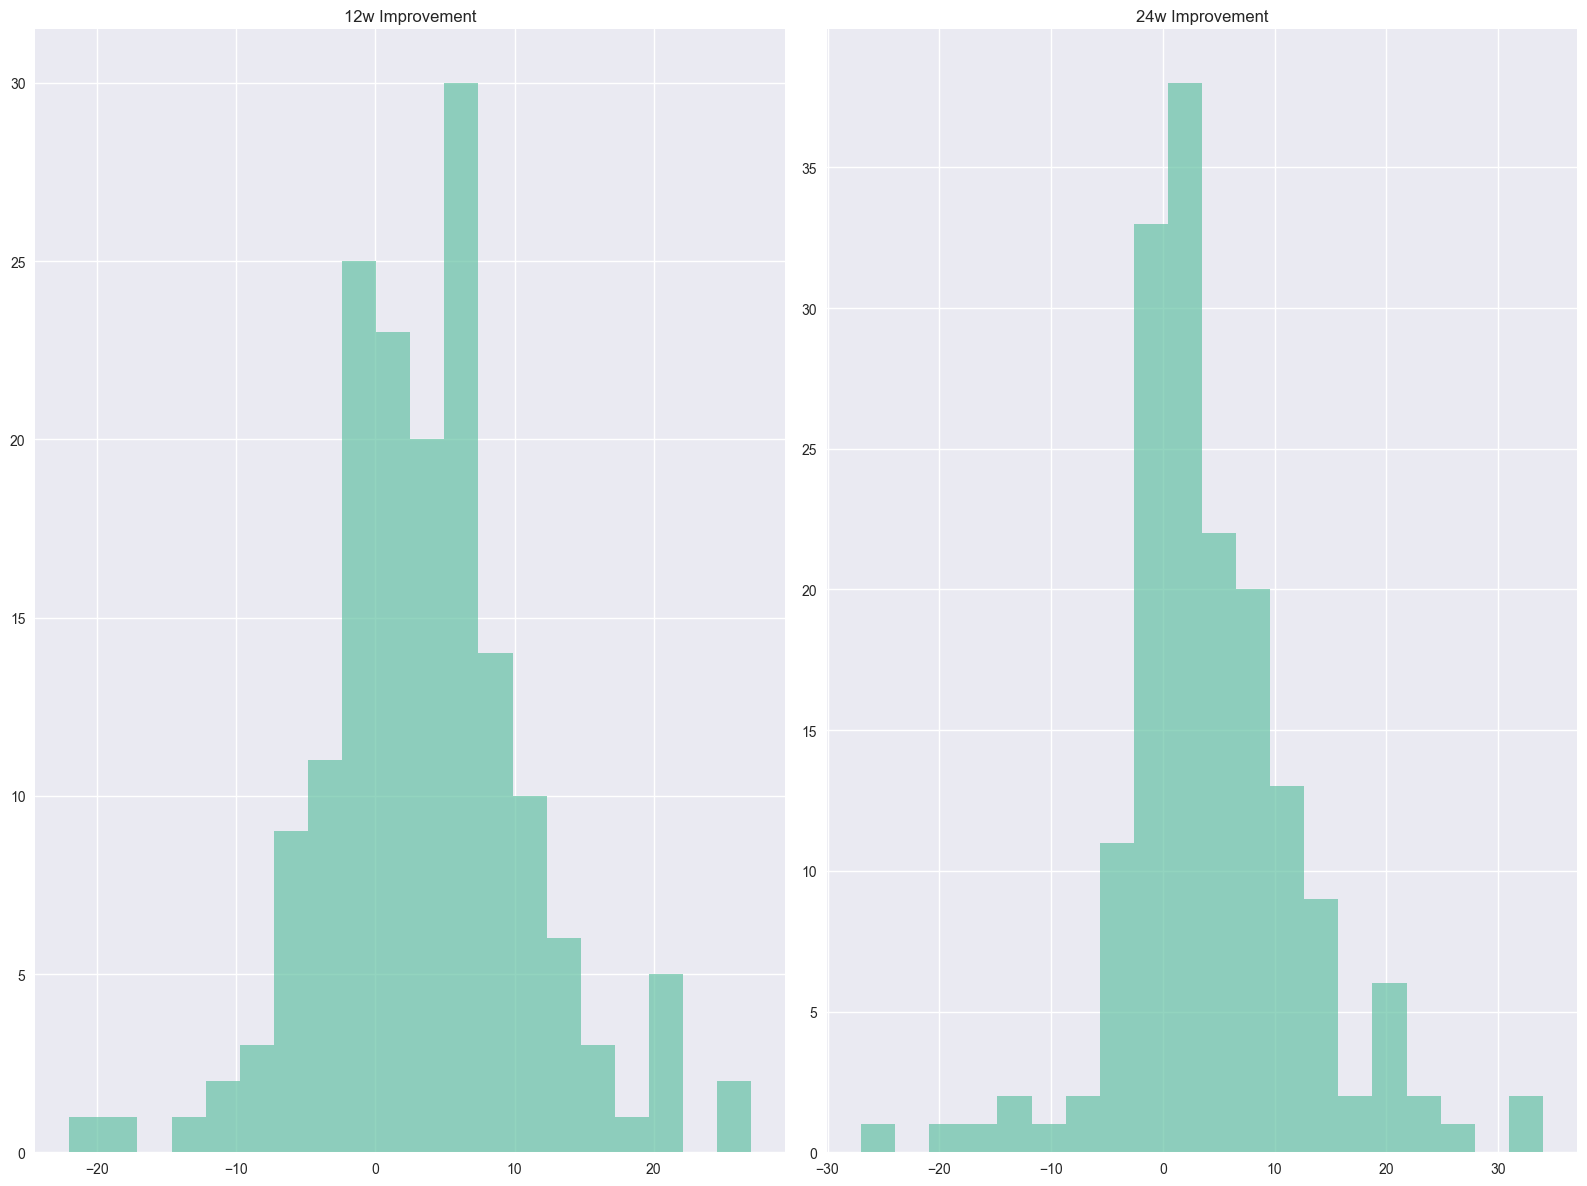


📊 Statistical Significance Tests (Wilcoxon Signed-Rank):
   Baseline vs 12w: p = 0.0000 ***
   Baseline vs 24w: p = 0.0000 ***
   12w vs 24w: p = 0.0859 ns


In [4]:
# 📊 Temporal Visualization - Depression Score Evolution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📈 Temporal Evolution of Depression Scores', fontsize=16, fontweight='bold')

# 1. Score distribution over time
time_data = pd.DataFrame({
    'Baseline': train_data['bdi_ii_baseline'],
    '12 Weeks': train_data['bdi_ii_after_intervention_12w'],
    '24 Weeks': train_data['bdi_ii_follow_up_24w']
})

time_data.boxplot(ax=axes[0,0])
axes[0,0].set_title('📊 BDI-II Score Distribution Over Time')
axes[0,0].set_ylabel('BDI-II Score')
axes[0,0].grid(True, alpha=0.3)

# 2. Individual trajectories (sample)
sample_idx = np.random.choice(len(train_data), 30, replace=False)
timepoints = [0, 12, 24]

for idx in sample_idx:
    scores = [
        train_data.iloc[idx]['bdi_ii_baseline'],
        train_data.iloc[idx]['bdi_ii_after_intervention_12w'],
        train_data.iloc[idx]['bdi_ii_follow_up_24w']
    ]
    axes[0,1].plot(timepoints, scores, alpha=0.4, linewidth=1)

axes[0,1].set_title('📈 Individual Patient Trajectories (Sample)')
axes[0,1].set_xlabel('Weeks')
axes[0,1].set_ylabel('BDI-II Score')
axes[0,1].grid(True, alpha=0.3)

# 3. Improvement distribution
improvement_data = pd.DataFrame({
    '12w Improvement': train_data['improvement_12w'],
    '24w Improvement': train_data['improvement_24w']
})

improvement_data.hist(bins=20, alpha=0.7, ax=axes[1,0])
axes[1,0].set_title('📊 Score Improvement Distribution')
axes[1,0].set_xlabel('Improvement Points')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend(['12 Weeks', '24 Weeks'])
axes[1,0].grid(True, alpha=0.3)

# 4. Response rates over time
response_rates = {
    'Response (≥50%)': [train_data['response_12w'].mean(), train_data['response_24w'].mean()],
    'Remission (≤13)': [train_data['remission_12w'].mean(), train_data['remission_24w'].mean()]
}

x = ['12 Weeks', '24 Weeks']
width = 0.35
x_pos = np.arange(len(x))

axes[1,1].bar(x_pos - width/2, response_rates['Response (≥50%)'], width, label='Response (≥50%)', alpha=0.8)
axes[1,1].bar(x_pos + width/2, response_rates['Remission (≤13)'], width, label='Remission (≤13)', alpha=0.8)
axes[1,1].set_title('🎯 Treatment Response Rates')
axes[1,1].set_ylabel('Rate')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(x)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests for temporal differences
stat_12w, p_12w = wilcoxon(train_data['bdi_ii_baseline'], train_data['bdi_ii_after_intervention_12w'])
stat_24w, p_24w = wilcoxon(train_data['bdi_ii_baseline'], train_data['bdi_ii_follow_up_24w'])
stat_12v24, p_12v24 = wilcoxon(train_data['bdi_ii_after_intervention_12w'], train_data['bdi_ii_follow_up_24w'])

print("\n📊 Statistical Significance Tests (Wilcoxon Signed-Rank):")
print(f"   Baseline vs 12w: p = {p_12w:.4f} {'***' if p_12w < 0.001 else '**' if p_12w < 0.01 else '*' if p_12w < 0.05 else 'ns'}")
print(f"   Baseline vs 24w: p = {p_24w:.4f} {'***' if p_24w < 0.001 else '**' if p_24w < 0.01 else '*' if p_24w < 0.05 else 'ns'}")
print(f"   12w vs 24w: p = {p_12v24:.4f} {'***' if p_12v24 < 0.001 else '**' if p_12v24 < 0.01 else '*' if p_12v24 < 0.05 else 'ns'}")

In [5]:
# 🧠 Rebuild GRU Models for Temporal Analysis
def create_gru_model(input_shape):
    """Create GRU model architecture"""
    model = Sequential([
        tf.keras.layers.Reshape((1, input_shape), input_shape=(input_shape,)),
        GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        GRU(32, dropout=0.2, recurrent_dropout=0.2),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Prepare data
X = train_data[feature_cols].values
y_12w = train_data['bdi_ii_after_intervention_12w'].values
y_24w = train_data['bdi_ii_follow_up_24w'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train models for both timepoints
print("🧠 Training GRU models for temporal analysis...")

models = {}
predictions = {}

for target_name, y_target in [('12w', y_12w), ('24w', y_24w)]:
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y_target, test_size=0.2, random_state=42
    )
    
    model = create_gru_model(X_scaled.shape[1])
    
    # Train with early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    )
    
    model.fit(X_train, y_train, 
              validation_data=(X_val, y_val),
              epochs=100, batch_size=16,
              callbacks=[early_stopping], verbose=0)
    
    models[target_name] = model
    predictions[target_name] = {
        'train': model.predict(X_train, verbose=0).flatten(),
        'val': model.predict(X_val, verbose=0).flatten(),
        'y_train': y_train,
        'y_val': y_val
    }
    
    # Performance metrics
    val_mae = mean_absolute_error(y_val, predictions[target_name]['val'])
    val_r2 = r2_score(y_val, predictions[target_name]['val'])
    
    print(f"   {target_name}: MAE = {val_mae:.3f}, R² = {val_r2:.3f}")

print("✅ Models trained successfully!")

🧠 Training GRU models for temporal analysis...
   12w: MAE = 4.181, R² = 0.100
   12w: MAE = 4.181, R² = 0.100
   24w: MAE = 4.341, R² = -0.101
✅ Models trained successfully!
   24w: MAE = 4.341, R² = -0.101
✅ Models trained successfully!


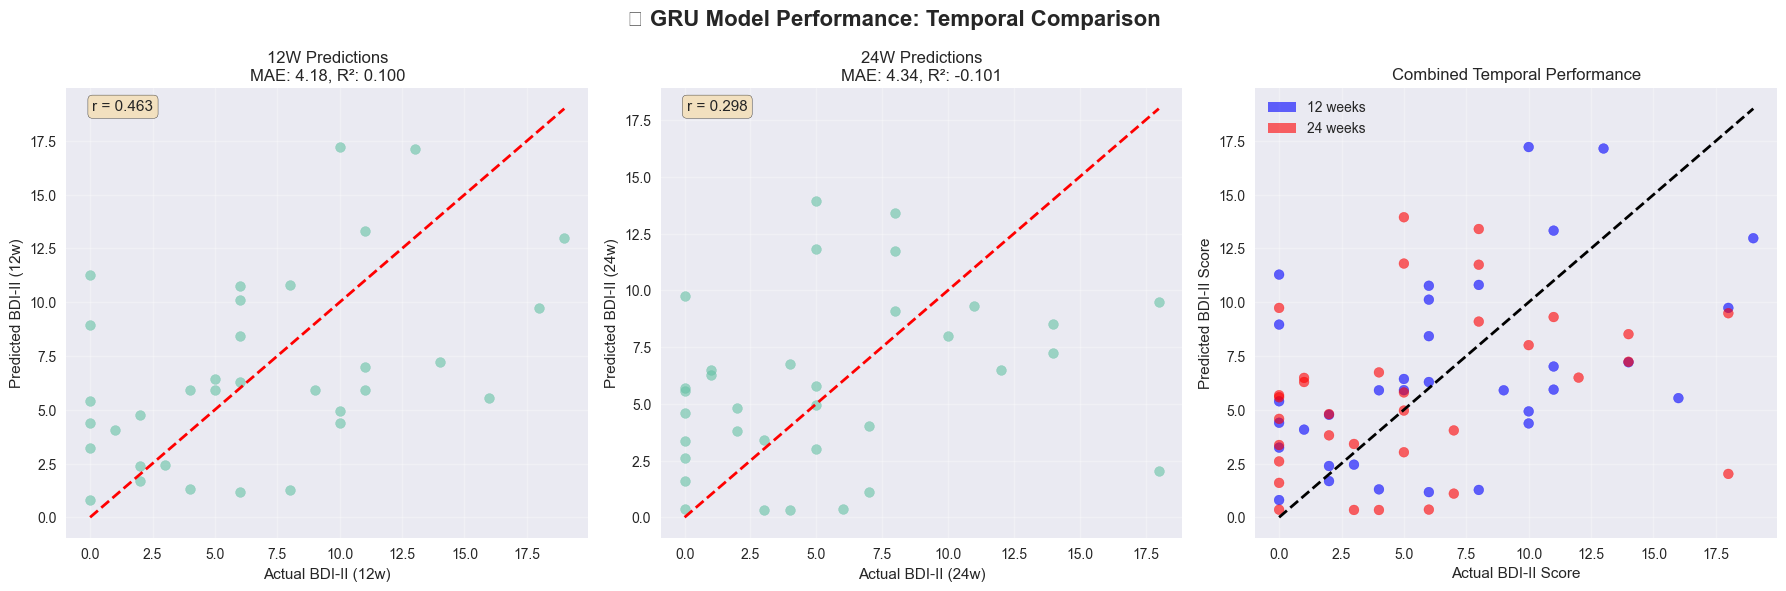

In [6]:
# 📊 Model Performance Comparison Across Timepoints
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('🧠 GRU Model Performance: Temporal Comparison', fontsize=16, fontweight='bold')

# Prediction vs Actual plots
for i, (target_name, pred_data) in enumerate(predictions.items()):
    y_true = pred_data['y_val']
    y_pred = pred_data['val']
    
    axes[i].scatter(y_true, y_pred, alpha=0.6, s=50)
    axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    axes[i].set_xlabel(f'Actual BDI-II ({target_name})')
    axes[i].set_ylabel(f'Predicted BDI-II ({target_name})')
    axes[i].set_title(f'{target_name.upper()} Predictions\nMAE: {mae:.2f}, R²: {r2:.3f}')
    axes[i].grid(True, alpha=0.3)
    
    # Add correlation text
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    axes[i].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[i].transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Combined comparison
all_actual = np.concatenate([predictions['12w']['y_val'], predictions['24w']['y_val']])
all_pred = np.concatenate([predictions['12w']['val'], predictions['24w']['val']])
timepoint_labels = ['12w'] * len(predictions['12w']['y_val']) + ['24w'] * len(predictions['24w']['y_val'])

# Color by timepoint
colors = ['blue' if label == '12w' else 'red' for label in timepoint_labels]
axes[2].scatter(all_actual, all_pred, c=colors, alpha=0.6, s=50)
axes[2].plot([all_actual.min(), all_actual.max()], [all_actual.min(), all_actual.max()], 'k--', lw=2)

axes[2].set_xlabel('Actual BDI-II Score')
axes[2].set_ylabel('Predicted BDI-II Score')
axes[2].set_title('Combined Temporal Performance')
axes[2].grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.6, label='12 weeks'),
                  Patch(facecolor='red', alpha=0.6, label='24 weeks')]
axes[2].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

In [7]:
# 🔍 Feature Importance Temporal Analysis
import shap

print("🔍 Computing temporal feature importance using SHAP...")

# Sample data for SHAP analysis
X_sample = X_scaled[:80]  # Background for explainer
X_explain = X_scaled[:40]  # Data to explain

# SHAP explainers for both models
explainer_12w = shap.Explainer(models['12w'], X_sample)
explainer_24w = shap.Explainer(models['24w'], X_sample)

shap_values_12w = explainer_12w(X_explain)
shap_values_24w = explainer_24w(X_explain)

# Calculate mean absolute SHAP values
shap_importance_12w = np.abs(shap_values_12w.values).mean(axis=0)
shap_importance_24w = np.abs(shap_values_24w.values).mean(axis=0)

# Create temporal importance comparison dataframe
temporal_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance_12w': shap_importance_12w,
    'importance_24w': shap_importance_24w
})

temporal_importance['importance_ratio'] = temporal_importance['importance_24w'] / (temporal_importance['importance_12w'] + 1e-8)
temporal_importance['importance_diff'] = temporal_importance['importance_24w'] - temporal_importance['importance_12w']
temporal_importance['avg_importance'] = (temporal_importance['importance_12w'] + temporal_importance['importance_24w']) / 2

print("✅ Temporal SHAP analysis completed!")

🔍 Computing temporal feature importance using SHAP...


PermutationExplainer explainer: 41it [00:17,  1.17it/s]                        

PermutationExplainer explainer: 41it [00:15,  1.09s/it]                        

✅ Temporal SHAP analysis completed!


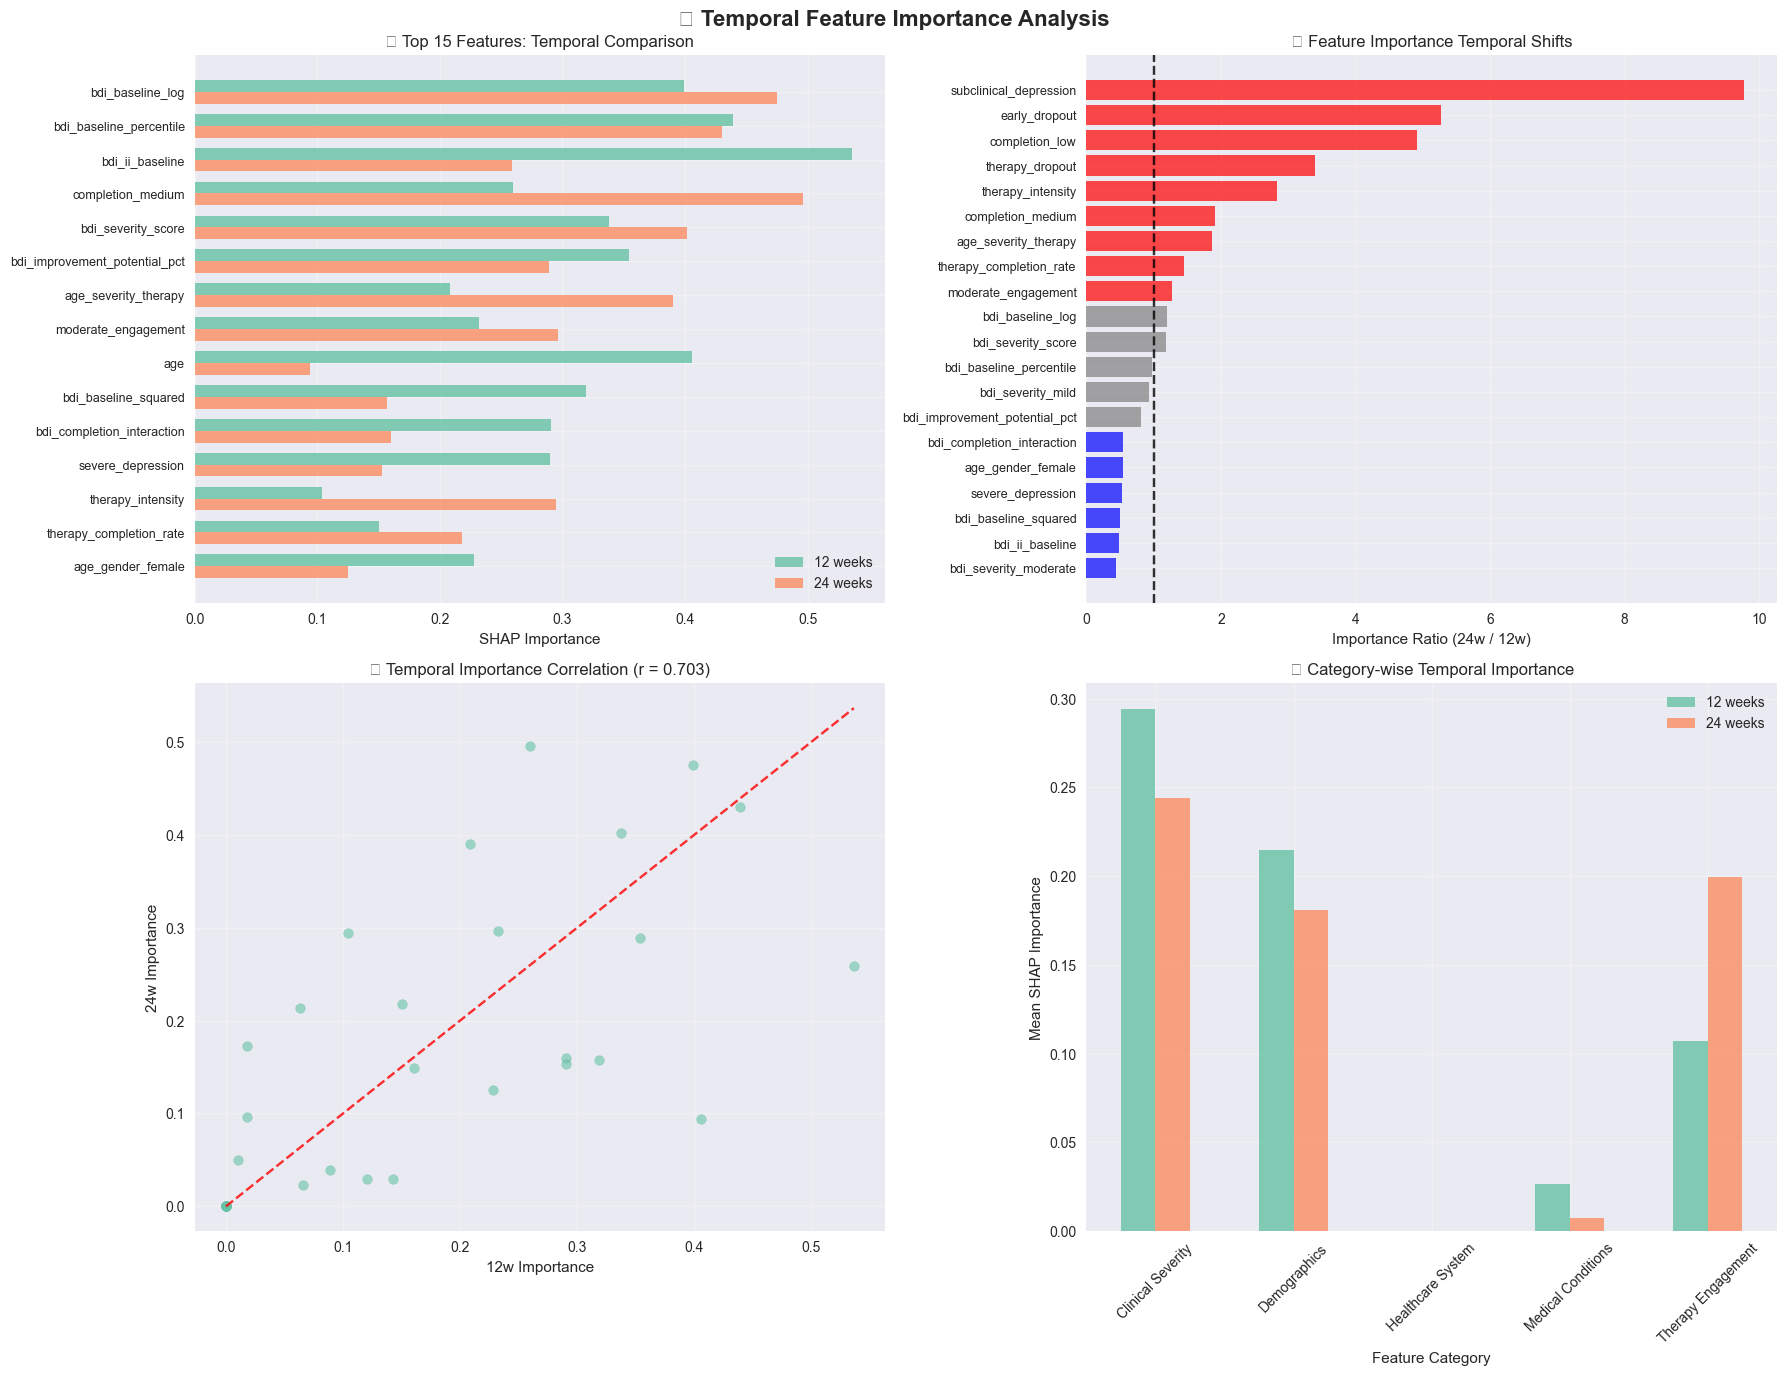


⏰ Temporal Feature Importance Insights:
   Correlation between 12w and 24w importance: 0.703
   Features more important at 24w (ratio > 1.2): 9
   Features more important at 12w (ratio < 0.8): 19


In [8]:
# 📊 Temporal Feature Importance Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('⏰ Temporal Feature Importance Analysis', fontsize=16, fontweight='bold')

# 1. Top features comparison
top_features = temporal_importance.nlargest(15, 'avg_importance')

x = np.arange(len(top_features))
width = 0.35

axes[0,0].barh(x - width/2, top_features['importance_12w'], width, label='12 weeks', alpha=0.8)
axes[0,0].barh(x + width/2, top_features['importance_24w'], width, label='24 weeks', alpha=0.8)
axes[0,0].set_yticks(x)
axes[0,0].set_yticklabels(top_features['feature'], fontsize=9)
axes[0,0].set_xlabel('SHAP Importance')
axes[0,0].set_title('🎯 Top 15 Features: Temporal Comparison')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].invert_yaxis()

# 2. Importance ratio analysis
temporal_importance_sorted = temporal_importance.sort_values('importance_ratio', ascending=False)
top_ratio_features = temporal_importance_sorted.head(20)

colors = ['red' if ratio > 1.2 else 'blue' if ratio < 0.8 else 'gray' for ratio in top_ratio_features['importance_ratio']]
axes[0,1].barh(range(len(top_ratio_features)), top_ratio_features['importance_ratio'], color=colors, alpha=0.7)
axes[0,1].set_yticks(range(len(top_ratio_features)))
axes[0,1].set_yticklabels(top_ratio_features['feature'], fontsize=9)
axes[0,1].set_xlabel('Importance Ratio (24w / 12w)')
axes[0,1].set_title('📈 Feature Importance Temporal Shifts')
axes[0,1].axvline(x=1, color='black', linestyle='--', alpha=0.8)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].invert_yaxis()

# 3. Correlation between timepoints
axes[1,0].scatter(temporal_importance['importance_12w'], temporal_importance['importance_24w'], alpha=0.6)
axes[1,0].plot([0, temporal_importance['importance_12w'].max()], 
               [0, temporal_importance['importance_12w'].max()], 'r--', alpha=0.8)
corr_temporal = temporal_importance['importance_12w'].corr(temporal_importance['importance_24w'])
axes[1,0].set_xlabel('12w Importance')
axes[1,0].set_ylabel('24w Importance')
axes[1,0].set_title(f'🔗 Temporal Importance Correlation (r = {corr_temporal:.3f})')
axes[1,0].grid(True, alpha=0.3)

# 4. Feature categories temporal analysis
def categorize_features(feature_name):
    feature_lower = feature_name.lower()
    if any(term in feature_lower for term in ['age', 'gender']):
        return 'Demographics'
    elif any(term in feature_lower for term in ['bdi', 'depression', 'severity']):
        return 'Clinical Severity'
    elif 'condition' in feature_lower:
        return 'Medical Conditions'
    elif any(term in feature_lower for term in ['therapy', 'completion', 'session', 'dropout']):
        return 'Therapy Engagement'
    elif 'hospital' in feature_lower:
        return 'Healthcare System'
    else:
        return 'Other'

temporal_importance['category'] = temporal_importance['feature'].apply(categorize_features)
category_temporal = temporal_importance.groupby('category')[['importance_12w', 'importance_24w']].mean()

category_temporal.plot(kind='bar', ax=axes[1,1], alpha=0.8, rot=45)
axes[1,1].set_title('📊 Category-wise Temporal Importance')
axes[1,1].set_xlabel('Feature Category')
axes[1,1].set_ylabel('Mean SHAP Importance')
axes[1,1].legend(['12 weeks', '24 weeks'])
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⏰ Temporal Feature Importance Insights:")
print(f"   Correlation between 12w and 24w importance: {corr_temporal:.3f}")
print(f"   Features more important at 24w (ratio > 1.2): {len(temporal_importance[temporal_importance['importance_ratio'] > 1.2])}")
print(f"   Features more important at 12w (ratio < 0.8): {len(temporal_importance[temporal_importance['importance_ratio'] < 0.8])}")

In [9]:
# 👥 Demographics Impact Over Time Analysis
print("👥 Analyzing demographic factors impact over time...")

# Identify demographic features
demographic_features = [f for f in feature_cols if any(term in f.lower() for term in ['age', 'gender'])]
clinical_features = [f for f in feature_cols if any(term in f.lower() for term in ['bdi', 'depression', 'severity'])]
therapy_features = [f for f in feature_cols if any(term in f.lower() for term in ['therapy', 'completion', 'session', 'dropout'])]
condition_features = [f for f in feature_cols if 'condition' in f.lower()]

print(f"   Demographic features: {len(demographic_features)}")
print(f"   Clinical features: {len(clinical_features)}")
print(f"   Therapy features: {len(therapy_features)}")
print(f"   Condition features: {len(condition_features)}")

# Analyze age impact if age data is available
if 'age' in train_data.columns:
    # Age group analysis
    age_median = train_data['age'].median()
    train_data['age_group'] = train_data['age'].apply(lambda x: 'Younger' if x < age_median else 'Older')
    
    # Age group outcomes
    age_outcomes = train_data.groupby('age_group').agg({
        'improvement_12w': ['mean', 'std'],
        'improvement_24w': ['mean', 'std'],
        'response_12w': 'mean',
        'response_24w': 'mean'
    }).round(3)
    
    print("\n👥 Age Group Analysis:")
    print(age_outcomes)

# Feature importance by category over time
feature_categories = {
    'Demographics': demographic_features,
    'Clinical': clinical_features,
    'Therapy': therapy_features,
    'Conditions': condition_features
}

category_importance_temporal = {}
for category, features in feature_categories.items():
    if features:  # Only if category has features
        cat_features_in_data = [f for f in features if f in temporal_importance['feature'].values]
        if cat_features_in_data:
            cat_data = temporal_importance[temporal_importance['feature'].isin(cat_features_in_data)]
            category_importance_temporal[category] = {
                'importance_12w': cat_data['importance_12w'].mean(),
                'importance_24w': cat_data['importance_24w'].mean(),
                'n_features': len(cat_features_in_data)
            }

print("\n📊 Category Importance Over Time:")
for category, data in category_importance_temporal.items():
    ratio = data['importance_24w'] / (data['importance_12w'] + 1e-8)
    print(f"   {category}: 12w={data['importance_12w']:.4f}, 24w={data['importance_24w']:.4f}, "
          f"ratio={ratio:.2f}, n_features={data['n_features']}")

👥 Analyzing demographic factors impact over time...
   Demographic features: 5
   Clinical features: 12
   Therapy features: 10
   Condition features: 7

👥 Age Group Analysis:
          improvement_12w        improvement_24w        response_12w  \
                     mean    std            mean    std         mean   
age_group                                                              
Older               3.978  6.727           4.764  7.944        0.472   
Younger             3.103  8.154           3.846  8.289        0.321   

          response_24w  
                  mean  
age_group               
Older            0.461  
Younger          0.410  

📊 Category Importance Over Time:
   Demographics: 12w=0.2149, 24w=0.1811, ratio=0.84, n_features=5
   Clinical: 12w=0.2868, 24w=0.2562, ratio=0.89, n_features=12
   Therapy: 12w=0.1313, 24w=0.1971, ratio=1.50, n_features=10
   Conditions: 12w=0.0265, 24w=0.0074, ratio=0.28, n_features=7


In [10]:
# 💊 Mindfulness Intervention Effectiveness Analysis
print("💊 Analyzing mindfulness intervention effectiveness over time...")

# Therapy-related features analysis
therapy_importance = temporal_importance[temporal_importance['feature'].isin(therapy_features)].copy()

if len(therapy_importance) > 0:
    therapy_importance_sorted = therapy_importance.sort_values('avg_importance', ascending=False)
    
    print("\n🎯 Top Therapy-Related Predictors:")
    for _, row in therapy_importance_sorted.head(10).iterrows():
        print(f"   {row['feature']:<30} | 12w: {row['importance_12w']:.4f} | 24w: {row['importance_24w']:.4f}")

# Analyze therapy completion impact
completion_features = [f for f in feature_cols if 'completion' in f.lower()]
dropout_features = [f for f in feature_cols if 'dropout' in f.lower()]

print(f"\n📊 Therapy Engagement Features:")
print(f"   Completion-related: {completion_features}")
print(f"   Dropout-related: {dropout_features}")

# Correlate therapy features with outcomes
therapy_outcome_corr = {}
for feature in therapy_features:
    if feature in train_data.columns:
        corr_12w = train_data[feature].corr(train_data['improvement_12w'])
        corr_24w = train_data[feature].corr(train_data['improvement_24w'])
        therapy_outcome_corr[feature] = {'12w': corr_12w, '24w': corr_24w}

if therapy_outcome_corr:
    print("\n🔗 Therapy Features Correlation with Improvement:")
    for feature, corrs in therapy_outcome_corr.items():
        print(f"   {feature:<30} | 12w: {corrs['12w']:.3f} | 24w: {corrs['24w']:.3f}")

💊 Analyzing mindfulness intervention effectiveness over time...

🎯 Top Therapy-Related Predictors:
   completion_medium              | 12w: 0.2598 | 24w: 0.4959
   age_severity_therapy           | 12w: 0.2084 | 24w: 0.3904
   bdi_completion_interaction     | 12w: 0.2908 | 24w: 0.1598
   therapy_intensity              | 12w: 0.1042 | 24w: 0.2948
   therapy_completion_rate        | 12w: 0.1503 | 24w: 0.2179
   therapy_dropout                | 12w: 0.0630 | 24w: 0.2137
   sessions_dropped               | 12w: 0.1428 | 24w: 0.0293
   early_dropout                  | 12w: 0.0182 | 24w: 0.0959
   condition_therapy_interaction  | 12w: 0.0655 | 24w: 0.0228
   completion_low                 | 12w: 0.0102 | 24w: 0.0502

📊 Therapy Engagement Features:
   Completion-related: ['bdi_completion_interaction', 'therapy_completion_rate', 'completion_medium', 'completion_low']
   Dropout-related: ['early_dropout', 'therapy_dropout']

🔗 Therapy Features Correlation with Improvement:
   bdi_completion_inte

📊 Identifying recovery patterns and trajectories...

🎯 Recovery Pattern Distribution:
   Non-Response              |  72 patients ( 43.1%)
   Sustained Response        |  45 patients ( 26.9%)
   Late Response             |  28 patients ( 16.8%)
   Early Response/Late Relapse |  22 patients ( 13.2%)


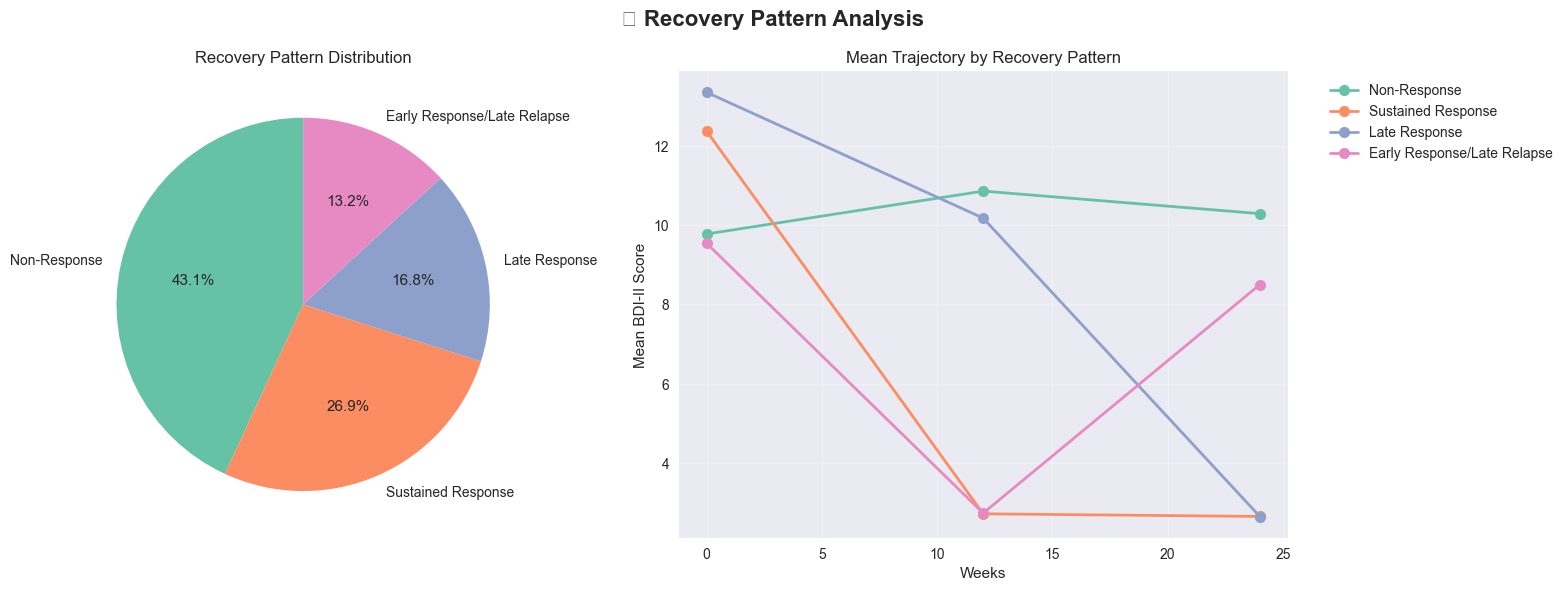

In [11]:
# 📊 Recovery Pattern Identification
print("📊 Identifying recovery patterns and trajectories...")

# Define recovery patterns
train_data['pattern'] = 'Other'

# Early responders (good at 12w, maintained at 24w)
early_responders = (train_data['response_12w'] == True) & (train_data['response_24w'] == True)
train_data.loc[early_responders, 'pattern'] = 'Sustained Response'

# Late responders (poor at 12w, good at 24w)
late_responders = (train_data['response_12w'] == False) & (train_data['response_24w'] == True)
train_data.loc[late_responders, 'pattern'] = 'Late Response'

# Deteriorating (good at 12w, poor at 24w)
deteriorating = (train_data['response_12w'] == True) & (train_data['response_24w'] == False)
train_data.loc[deteriorating, 'pattern'] = 'Early Response/Late Relapse'

# Non-responders (poor at both)
non_responders = (train_data['response_12w'] == False) & (train_data['response_24w'] == False)
train_data.loc[non_responders, 'pattern'] = 'Non-Response'

pattern_counts = train_data['pattern'].value_counts()
print("\n🎯 Recovery Pattern Distribution:")
for pattern, count in pattern_counts.items():
    percentage = (count / len(train_data)) * 100
    print(f"   {pattern:<25} | {count:3d} patients ({percentage:5.1f}%)")

# Visualize recovery patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('🎯 Recovery Pattern Analysis', fontsize=16, fontweight='bold')

# Pattern distribution pie chart
axes[0].pie(pattern_counts.values, labels=pattern_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Recovery Pattern Distribution')

# Trajectory visualization by pattern
for pattern in pattern_counts.index:
    pattern_data = train_data[train_data['pattern'] == pattern]
    if len(pattern_data) > 0:
        mean_baseline = pattern_data['bdi_ii_baseline'].mean()
        mean_12w = pattern_data['bdi_ii_after_intervention_12w'].mean()
        mean_24w = pattern_data['bdi_ii_follow_up_24w'].mean()
        
        axes[1].plot([0, 12, 24], [mean_baseline, mean_12w, mean_24w], 
                    marker='o', linewidth=2, label=pattern, markersize=8)

axes[1].set_xlabel('Weeks')
axes[1].set_ylabel('Mean BDI-II Score')
axes[1].set_title('Mean Trajectory by Recovery Pattern')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# 🔍 Pattern-Specific Feature Analysis
print("🔍 Analyzing features associated with different recovery patterns...")

# Compare feature values across patterns
pattern_feature_analysis = {}

# Select top important features for analysis
top_features_for_patterns = temporal_importance.nlargest(20, 'avg_importance')['feature'].tolist()

for pattern in pattern_counts.index:
    pattern_data = train_data[train_data['pattern'] == pattern]
    if len(pattern_data) > 5:  # Only analyze patterns with sufficient data
        pattern_features = {}
        for feature in top_features_for_patterns:
            if feature in train_data.columns:
                pattern_features[feature] = {
                    'mean': pattern_data[feature].mean(),
                    'std': pattern_data[feature].std()
                }
        pattern_feature_analysis[pattern] = pattern_features

# Statistical comparison between patterns
pattern_comparison = []
for feature in top_features_for_patterns[:10]:  # Top 10 features
    if feature in train_data.columns:
        # Compare sustained response vs non-response
        sustained = train_data[train_data['pattern'] == 'Sustained Response'][feature]
        non_response = train_data[train_data['pattern'] == 'Non-Response'][feature]
        
        if len(sustained) > 0 and len(non_response) > 0:
            stat, p_val = mannwhitneyu(sustained, non_response, alternative='two-sided')
            pattern_comparison.append({
                'feature': feature,
                'sustained_mean': sustained.mean(),
                'non_response_mean': non_response.mean(),
                'p_value': p_val,
                'significant': p_val < 0.05
            })

pattern_comparison_df = pd.DataFrame(pattern_comparison).sort_values('p_value')

print("\n🎯 Features Distinguishing Sustained Response vs Non-Response:")
print("="*80)
for _, row in pattern_comparison_df.head(10).iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else "ns"
    print(f"{row['feature']:<30} | Sustained: {row['sustained_mean']:.3f} | Non-resp: {row['non_response_mean']:.3f} | p={row['p_value']:.4f} {sig}")

# Visualize pattern differences
if len(pattern_comparison_df) > 0:
    significant_features = pattern_comparison_df[pattern_comparison_df['significant']]
    
    if len(significant_features) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        x = np.arange(len(significant_features))
        width = 0.35
        
        ax.bar(x - width/2, significant_features['sustained_mean'], width, 
               label='Sustained Response', alpha=0.8)
        ax.bar(x + width/2, significant_features['non_response_mean'], width, 
               label='Non-Response', alpha=0.8)
        
        ax.set_xlabel('Features')
        ax.set_ylabel('Mean Feature Value')
        ax.set_title('🎯 Significant Features: Sustained Response vs Non-Response')
        ax.set_xticks(x)
        ax.set_xticklabels(significant_features['feature'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

🔍 Analyzing features associated with different recovery patterns...

🎯 Features Distinguishing Sustained Response vs Non-Response:
bdi_baseline_log               | Sustained: 2.353 | Non-resp: 1.991 | p=0.1026 ns
bdi_baseline_percentile        | Sustained: 0.539 | Non-resp: 0.447 | p=0.1026 ns
bdi_ii_baseline                | Sustained: 12.378 | Non-resp: 9.778 | p=0.1026 ns
bdi_improvement_potential_pct  | Sustained: 0.804 | Non-resp: 0.845 | p=0.1026 ns
bdi_baseline_squared           | Sustained: 236.289 | Non-resp: 169.778 | p=0.1026 ns
bdi_severity_score             | Sustained: 0.600 | Non-resp: 0.375 | p=0.1232 ns
completion_medium              | Sustained: 0.200 | Non-resp: 0.306 | p=0.2114 ns
age_severity_therapy           | Sustained: 28.146 | Non-resp: 16.930 | p=0.2826 ns
moderate_engagement            | Sustained: 0.311 | Non-resp: 0.375 | p=0.4850 ns
age                            | Sustained: 64.733 | Non-resp: 64.583 | p=0.4869 ns


In [13]:
# 📋 Comprehensive Temporal Analysis Summary
print("\n" + "="*100)
print("⏰ COMPREHENSIVE TEMPORAL IMPACT ANALYSIS SUMMARY")
print("="*100)

# Overall temporal insights
print("\n🎯 KEY TEMPORAL INSIGHTS:")

# 1. Overall improvement patterns
mean_improvement_12w = train_data['improvement_12w'].mean()
mean_improvement_24w = train_data['improvement_24w'].mean()
print(f"\n📊 OVERALL IMPROVEMENT:")
print(f"   12-week improvement: {mean_improvement_12w:.1f} points")
print(f"   24-week improvement: {mean_improvement_24w:.1f} points")
print(f"   Additional improvement 12w→24w: {mean_improvement_24w - mean_improvement_12w:.1f} points")

# 2. Response and remission rates
response_12w_rate = train_data['response_12w'].mean() * 100
response_24w_rate = train_data['response_24w'].mean() * 100
remission_12w_rate = train_data['remission_12w'].mean() * 100
remission_24w_rate = train_data['remission_24w'].mean() * 100

print(f"\n🎯 CLINICAL RESPONSE RATES:")
print(f"   12w Response: {response_12w_rate:.1f}% | 24w Response: {response_24w_rate:.1f}%")
print(f"   12w Remission: {remission_12w_rate:.1f}% | 24w Remission: {remission_24w_rate:.1f}%")

# 3. Feature importance temporal stability
stable_features = temporal_importance[
    (temporal_importance['importance_ratio'] >= 0.8) & 
    (temporal_importance['importance_ratio'] <= 1.2)
]
increasing_features = temporal_importance[temporal_importance['importance_ratio'] > 1.2]
decreasing_features = temporal_importance[temporal_importance['importance_ratio'] < 0.8]

print(f"\n🔄 FEATURE IMPORTANCE TEMPORAL PATTERNS:")
print(f"   Stable features (12w ≈ 24w): {len(stable_features)} ({len(stable_features)/len(temporal_importance)*100:.1f}%)")
print(f"   More important at 24w: {len(increasing_features)} features")
print(f"   More important at 12w: {len(decreasing_features)} features")

# 4. Top temporal shifters
print(f"\n📈 TOP FEATURES GAINING IMPORTANCE OVER TIME:")
for _, row in increasing_features.nlargest(5, 'importance_ratio').iterrows():
    print(f"   {row['feature']:<30} | Ratio: {row['importance_ratio']:.2f}")

print(f"\n📉 TOP FEATURES LOSING IMPORTANCE OVER TIME:")
for _, row in decreasing_features.nsmallest(5, 'importance_ratio').iterrows():
    print(f"   {row['feature']:<30} | Ratio: {row['importance_ratio']:.2f}")

# 5. Recovery patterns summary
print(f"\n🎯 RECOVERY PATTERN DISTRIBUTION:")
for pattern, count in pattern_counts.items():
    percentage = (count / len(train_data)) * 100
    print(f"   {pattern:<25} | {count:3d} patients ({percentage:5.1f}%)")

# 6. Model performance temporal comparison
mae_12w = mean_absolute_error(predictions['12w']['y_val'], predictions['12w']['val'])
mae_24w = mean_absolute_error(predictions['24w']['y_val'], predictions['24w']['val'])
r2_12w = r2_score(predictions['12w']['y_val'], predictions['12w']['val'])
r2_24w = r2_score(predictions['24w']['y_val'], predictions['24w']['val'])

print(f"\n🧠 GRU MODEL PERFORMANCE COMPARISON:")
print(f"   12w prediction: MAE = {mae_12w:.3f}, R² = {r2_12w:.3f}")
print(f"   24w prediction: MAE = {mae_24w:.3f}, R² = {r2_24w:.3f}")
print(f"   Performance difference: ΔMAE = {mae_24w - mae_12w:+.3f}, ΔR² = {r2_24w - r2_12w:+.3f}")

print("\n" + "="*100)
print("✅ TEMPORAL IMPACT ANALYSIS COMPLETE")
print("="*100)

# Save temporal analysis results
temporal_analysis_summary = {
    'analysis_date': datetime.now().isoformat(),
    'overall_improvement': {
        '12w': float(mean_improvement_12w),
        '24w': float(mean_improvement_24w)
    },
    'response_rates': {
        '12w_response': float(response_12w_rate),
        '24w_response': float(response_24w_rate),
        '12w_remission': float(remission_12w_rate),
        '24w_remission': float(remission_24w_rate)
    },
    'feature_temporal_patterns': {
        'stable_features': len(stable_features),
        'increasing_features': len(increasing_features),
        'decreasing_features': len(decreasing_features)
    },
    'recovery_patterns': pattern_counts.to_dict(),
    'model_performance': {
        '12w': {'mae': float(mae_12w), 'r2': float(r2_12w)},
        '24w': {'mae': float(mae_24w), 'r2': float(r2_24w)}
    }
}

with open(RESULTS_PATH / 'temporal_analysis_summary.json', 'w') as f:
    json.dump(temporal_analysis_summary, f, indent=2)

# Save detailed temporal importance
temporal_importance.to_csv(RESULTS_PATH / 'temporal_feature_importance.csv', index=False)

print("\n💾 Temporal analysis results saved!")


⏰ COMPREHENSIVE TEMPORAL IMPACT ANALYSIS SUMMARY

🎯 KEY TEMPORAL INSIGHTS:

📊 OVERALL IMPROVEMENT:
   12-week improvement: 3.6 points
   24-week improvement: 4.3 points
   Additional improvement 12w→24w: 0.8 points

🎯 CLINICAL RESPONSE RATES:
   12w Response: 40.1% | 24w Response: 43.7%
   12w Remission: 83.8% | 24w Remission: 85.0%

🔄 FEATURE IMPORTANCE TEMPORAL PATTERNS:
   Stable features (12w ≈ 24w): 5 (15.2%)
   More important at 24w: 9 features
   More important at 12w: 19 features

📈 TOP FEATURES GAINING IMPORTANCE OVER TIME:
   subclinical_depression         | Ratio: 9.77
   early_dropout                  | Ratio: 5.27
   completion_low                 | Ratio: 4.92
   therapy_dropout                | Ratio: 3.39
   therapy_intensity              | Ratio: 2.83

📉 TOP FEATURES LOSING IMPORTANCE OVER TIME:
   hospital_center_id             | Ratio: 0.00
   condition_acute_coronary_syndrome | Ratio: 0.00
   condition_complexity_score     | Ratio: 0.00
   hospital_patient_volume  